# NLE Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [1]:
candidateno=XXXXX

In [2]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Tasha\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [3]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [4]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['one', 'of', 'the', 'more', 'unusual', 'and', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [5]:
#Pre-processing code
stops = stopwords.words('english') #and, the, of... etc

def normalisation(words):
    """
    Given a list of words, e.g. training or testing,
    this function returns the same list without punctuation or
    stop words
    """
    #excludes punctuation and numeric values and stopwords
    normalised_list = [word for word in words if word.isalpha() and word not in stops]
    
    return normalised_list

#creates normalised training and test sets
training_norm=[(FreqDist(normalisation(wordlist)),label) for (wordlist,label) in training_data]
testing_norm=[(FreqDist(normalisation(wordlist)),label) for (wordlist,label) in testing_data]

#returns most common words for its argument
pos_freq_dist=FreqDist()
neg_freq_dist=FreqDist()

#seperates training set into its positive and negative distribution lists
for distribution,label in training_norm:
    if label=='pos':
        pos_freq_dist+=distribution #add most frequent in pos reviews to pos_freq_dist
    else:
        neg_freq_dist+=distribution #add most frequent in neg reviews to neg_freq_dist
        


In [6]:
#Word frequency for each sentiment
def common_words(dist1,dist2,n):
    
    """
    This function takes two distributions, in this case
    positive and negative, and returns the n most common
    words, taking into account the likelihood they occur
    within one distribution over the other
    
    dist1: first sentiment distribution
    dist2: second sentiment distribution
    n: number of words to put in wordlist
    """
    #how prevalent a word is in one set over the other
    difference = dist1-dist2
    #returns the n most common words,uses python counter class method, most_common()
    n_common = difference.most_common(n) 
    
    common_list = [word for (word,freq) in n_common] #list of just the words
    
    return common_list

In [7]:
#QUESTION 1A
pos_common = common_words(pos_freq_dist,neg_freq_dist,10)
print(pos_common)

['film', 'life', 'also', 'great', 'world', 'one', 'best', 'well', 'story', 'many']


In [8]:
#QUESTION 1B
neg_common = common_words(neg_freq_dist,pos_freq_dist,10)
#note by switching order of dists we make the difference positive instead of neg and dont need to worry about sign
print(neg_common)

['movie', 'bad', 'plot', 'get', 'even', 'worst', 'stupid', 'could', 'boring', 'script']


In [34]:
#for easy viewing
import numpy as np
data = {'positive': pos_common,
        'negative': neg_common}

df = pd.DataFrame(data)
df.index = np.arange(1, len(df)+1)
df

,positive,negative
1,film,movie
2,life,bad
3,also,plot
4,great,get
5,world,even
6,one,worst
7,best,stupid
8,well,could
9,story,boring
10,many,script


After importing the movie review corpus from nltk, the review data was cleaned so that unneccesary information such as stop-words, punctuation and numerical data were removed. Nltk's stopword method was also used to avoid having to create it manually - stop words are not universal, but are general common words in a given language which provide little to no relevance within a text. This step was necessary as the removed information was unlikely to reflect the sentiment of the reviews. Decreasing the amount of data to iterate over in the dataset will also speed up training and classifying times, which is an additional advantage.

The frequency distribution of the positive and negative reviews were then derived using the FreqDist() method. This is done because if an example in the test data shows a word which was commonly found in the training data, then they are likely to be the same class - the likelihood is assigned by placing a word in the positive or negative distribution list. The function common_words() was then created to derive a list of the n most positive words. Some words may appear in both positive and negative reviews, which is why it was important to take the difference of the frequency of a word for positive and negative reviews. By doing this, a list of words which were more common in one category over the other is found. This theoretically should have given mostly positive words for the pos_common list and mostly negative for the neg_common list. 

When displaying the 10 most common words for each sentiment, it can be seen that they are not particularly relevant to the respective sentiment. By comparing lists, there are actually only 2-4 words that could objectively be considered as words relating to sentiment. A possible way to combat this, although beyond the scope of this module, (currently!), would be to create a part-of-speech tagging system and then eliminate words which may be unrelated to sentiment - e.g. non-adjective terms.

2) 
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [10]:
class SimpleClassifier(ClassifierI): 
    """
    Ideal for when we give the class a wordlist of our own creation
    
    parameters:
        word: collection of documents with a frequency distribution
        k: number to of most common words to take as an argument"""
    
    def __init__(self, pos, neg): 
        self._pos = pos 
        self._neg = neg
        
    def classify(self, word): 
        #initialise score to 0
        score = 0
        
        #score becomes negative if a word is found in negative reviews, positive if in positive reviews
        for words,value in word.items():
            if words in self._pos:
                score += value
            if words in self._neg:
                score -= value

        return "neg" if score < 0 else "pos"

    def labels(self): 
        return ("pos", "neg")

class SimpleClassifier_mf(SimpleClassifier):
    """
    This class inherits the same arguments that the SimpleClassifier takes,
    but also has its own parameters. It is used to generate a wordlist based
    on the most common words seen in each review list.
    
    train function takes training_data as an argument which was created
    earlier in the get_train_test_data function"""
    
    def __init__(self,k):
        self._k=k
    
    def train(self,training_data):
        
        #get distributions in training data
        pos_freq_dist=FreqDist()
        neg_freq_dist=FreqDist()

        for distribution,label in training_data:
            #add positive distributions to p_f_d
            if label=='pos': 
                pos_freq_dist+=distribution
            #add everything else to n_f_d
            else:
                neg_freq_dist+=distribution
        
        #swap frequency lists around to get positive or negative respectively
        self._pos=common_words(pos_freq_dist,neg_freq_dist,self._k)
        self._neg=common_words(neg_freq_dist,pos_freq_dist,self._k)

movieclassifier=SimpleClassifier_mf(100) #example: 100 most common words 
movieclassifier.train(training_norm) #use normalised list to train with

In [11]:
#split list of pairs to pair of lists
testing,labels=zip(*testing_norm)

sentiments = []
sent = movieclassifier.classify_many(testing)
sentiments.append(sent)

In [35]:
#example of docs classified
dataset = {'Reviews': list(testing[0:20]),
           'Sentiment': sent[0:20]}

df = pd.DataFrame(dataset)
df

,Reviews,Sentiment
0,"{'films': 1, 'adapted': 1, 'comic': 5, 'books'...",neg
1,"{'may': 3, 'seem': 2, 'weird': 1, 'begin': 1, ...",pos
2,"{'got': 2, 'mail': 2, 'works': 1, 'alot': 1, '...",pos
3,"{'krippendorf': 6, 'tribe': 8, 'formula': 1, '...",pos
4,"{'apparently': 1, 'director': 2, 'tony': 3, 'k...",pos
5,"{'bloody': 1, 'clashes': 1, 'independence': 1,...",pos
6,"{'american': 1, 'action': 4, 'film': 5, 'slowl...",pos
7,"{'watching': 1, 'rat': 3, 'race': 5, 'last': 1...",pos
8,"{'even': 2, 'know': 2, 'director': 2, 'co': 1,...",pos
9,"{'carry': 2, 'matron': 6, 'last': 1, 'great': ...",pos


For the word list classifier, two classed were created: SimpleClassifier and SimpleClassifier_mf. The second class inherits from the first class and the first class takes the argument ClassifierI from nltk.classify. This enables the type of classification e.g. binary classes, rather than multiple classes. The second class gets all the same methods and arguments that the first class gets, however the distinction has been made so that a word list of 0, i.e. k = none, can be passed in the experiments for section 5.

The classifier generates its own word lists using the frequency distribution methods seen in question 1. The train method calls these functions on an object to get the distributions from the training set. The first class defines the classification method in terms of a classes score: where a labelled review is positive, each word gets passed to a list where its FreqDist() is found, vice versa for negative reviews. The second class redefines the word lists as the most common words in each category, as defined in question 1. The classify_many method is eventually called which allows multiple arguments to be classified, which is the entire test set in this context. In order for the test set to be appropriately classified, the labels were removed so that just the words were present. The wordlist size was also set to 100, as the 100 most common words seemed appropriate to obtain a varied wordlist.

The data-frame was created to get a more complete overview as to which reviews were being classified as which class, although it was difficult to estimate given that the majority of the reviews were classed as positive.

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

In [13]:
def cls_metrics(classifier, test_data):
    """
    classifier is the classify method used to determine the sentiment of the review
    test_data is the data which was held back intially in the test_train_split function
    
    """
    #initialise counters
    TP = 0 #classified as positive and correct
    FP = 0 #classified as positive and wrong
    TN = 0 #classified as negative and correct
    FN = 0 #classified as negative and false
    correct = 0
    
    #separate test data into their respective parts
    tests, correct_label = zip(*test_data)
    #get prediction for every test_data review
    preds = classifier.classify_many(tests)
    
    for predictions, true in zip(preds, correct_label):
        if true == predictions== 'pos':
            correct += 1 #for accuracy
            TP += 1 
        if predictions == 'pos' and true != predictions:
            FP += 1
        if true == predictions == 'neg' :
            correct += 1 #for accuracy
            TN += 1
        if predictions == 'neg' and true != predictions:
            FN += 1
    
    #formulas for metrics
    accuracy = correct/(len(preds))
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = (2*precision*recall)/(precision+recall)
    
    
    return(accuracy, TP, FP, TN, FN, precision, recall, F1)

 The accuracy is: 64.66666666666666%
 The precision is: 59.166666666666664%
 The recall is: 94.66666666666667%
 The F1 score is: 0.7282051282051282


[Text(0, 0.5, 'True'), Text(0, 1.5, 'False')]

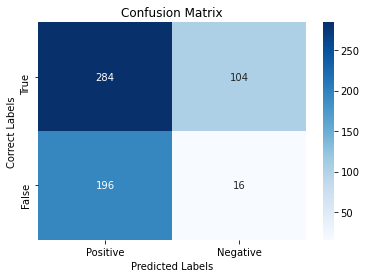

In [14]:
#nice displays for confusion matrix
#libraries for nice visuals
import seaborn as sns
import matplotlib.pyplot as plt

#get metrics from above function into easily callable list
metrics = cls_metrics(movieclassifier, testing_norm)
plotstr = print(" The accuracy is: {}%\n".format(metrics[0]*100,),
                "The precision is: {}%\n".format(metrics[5]*100, ),
                "The recall is: {}%\n".format(metrics[6]*100),
                "The F1 score is: {}".format(metrics[7]))
plotstr
#set up in order i want, can change but change the labels to match
data_set = [[metrics[1], metrics[3]], [metrics[2],metrics[4]]]

ax = plt.subplot()
#seaborn heatmap method, annot = display values, fmt = get rid of scientific notation, cmap = colours
sns.heatmap(data_set, annot = True, fmt = 'g', ax = ax, cmap = 'Blues' )

#label nicely
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Correct Labels")
ax.xaxis.set_ticklabels(["Positive", "Negative"])
ax.yaxis.set_ticklabels(["True", "False"])



Part B and explanation of above: 

Accuracy shows the number of correctly classified documents from the test set. Recall shows the number of actually positive documents that were predicted as correct and precision shows the proportion of positive predictions that were correct. To consider a classifier as good, the precision and recall should be quite high. A combined metric can be derived from precision and recall metrics, called the F1 score. Although this classifier has a high recall, the precision is lower than ideal. This can be solved by implementing a different decision boundary, making the classifier less likely to classify results as positive. To do this, we could change the SimpleClassifier_mf class so that the negative wordlist is redefined such that score < 5 (for example) would return a negative label instead of score < 0.

Whilst accuracy is the traditional method for evaluating classes, it usually fails on imbalanced classes. From the code cell below, it can be seen that our training data is mostly positive, thus imbalanced. The effect of this can be seen in the metrics - the recall for our classifier is very high. This is because if a great proportion of training data was mostly positive, then our classifier is going to generalise most test data as positive too as it is less familiar with what negative actually means.

Although the accuracy I obtained was average, more severely skewed datasets may produce different results. For example in a dataset of 1000, if 999 were positive, we would probably get accuracy results of 99%+ as they would all be classified as positive. For this particular dataset it would be true, but if a balanced dataset was given, the accuracy is likely to decrease significantly. In order to use accuracy as a valid metric, there must be good quality training data.

In [15]:
print(training_data[0:20])

[(['one', 'of', 'the', 'more', 'unusual', 'and', ...], 'pos'), (['when', 'andy', 'leaves', 'for', 'cowboy', 'camp', ...], 'pos'), (['taking', 'a', 'few', 'tips', 'from', 'the', 'pulp', ...], 'pos'), (['upon', 'taking', 'a', 'seat', 'at', 'the', 'theater', ...], 'pos'), (['i', 'didn', "'", 't', 'realize', 'how', 'apt', 'the', ...], 'pos'), (['the', 'happy', 'bastard', "'", 's', '30', '-', ...], 'pos'), (['ladies', 'and', 'gentlemen', ',', '1997', "'", 's', ...], 'pos'), (['with', 'the', 'opening', 'scene', 'of', 'a', 'young', ...], 'pos'), (['the', 'central', 'focus', 'of', 'michael', ...], 'pos'), (['sometimes', 'a', 'movie', 'comes', 'along', 'that', ...], 'pos'), (['steve', 'martin', 'took', 'an', 'extended', ...], 'pos'), (['this', 'has', 'some', 'major', 'spoilers', 'for', ...], 'pos'), (['in', '1977', ',', 'something', 'never', 'though', ...], 'pos'), (['scream', '2', ',', 'like', 'its', 'predecessor', ',', ...], 'pos'), (['one', 'of', 'the', 'sweetest', 'tales', 'to', 'ever', ...

4) 
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results. 

[12.5\%]

In [16]:
from nltk.classify import NaiveBayesClassifier as nbc

N_B = nbc.train(training_norm)
N_B.classify_many(testing)


['pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',


In [17]:
#redefine classifiers for metric comparison
wordlist_cls = SimpleClassifier_mf(100)
wordlist_cls.train(training_norm)
wordlist_cls.classify_many(testing)

#copied again for easy viewing
metrics_comp = cls_metrics(wordlist_cls, testing_norm)
plotstr = print("For the wordlist classifier \n",
                "The accuracy is: {}%\n".format(metrics_comp[0]*100,),
                "The precision is: {}%\n".format(metrics_comp[5]*100, ),
                "The recall is: {}%\n".format(metrics_comp[6]*100),
                "The F1 score is: {}\n".format(metrics_comp[7]))

metrics_comp2 = cls_metrics(N_B, testing_norm)
plotstr2 = print("For the Naive-Bayes classifier \n", 
                 "The accuracy is: {}%\n".format(metrics_comp2[0]*100,),
                "The precision is: {}%\n".format(metrics_comp2[5]*100, ),
                "The recall is: {}%\n".format(metrics_comp2[6]*100),
                "The F1 score is: {}".format(metrics_comp2[7]))

For the wordlist classifier 
 The accuracy is: 64.66666666666666%
 The precision is: 59.166666666666664%
 The recall is: 94.66666666666667%
 The F1 score is: 0.7282051282051282

For the Naive-Bayes classifier 
 The accuracy is: 69.66666666666667%
 The precision is: 62.60683760683761%
 The recall is: 97.66666666666667%
 The F1 score is: 0.7630208333333335


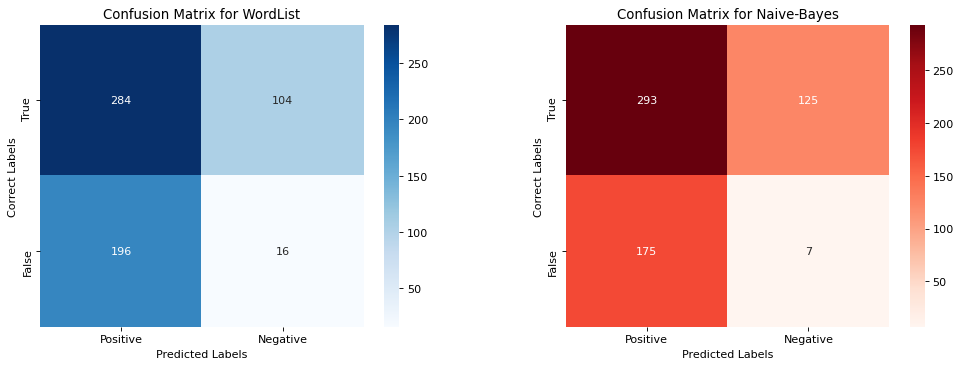

In [18]:
#plot comparison (see first heat map for further comments)
#WordList
from matplotlib.pyplot import figure
figure(figsize=(15, 5), dpi=80) #formatting figures and size
       
ax1 = plt.subplot(1, 2, 1) 
data_set = [[metrics_comp[1], metrics_comp[3]], [metrics_comp[2],metrics_comp[4]]]
sns.heatmap(data_set, annot = True, fmt = 'g', ax = ax1, cmap = 'Blues' )
ax1.set_title("Confusion Matrix for WordList")
ax1.set_xlabel("Predicted Labels")
ax1.set_ylabel("Correct Labels")
ax1.xaxis.set_ticklabels(["Positive", "Negative"])
ax1.yaxis.set_ticklabels(["True", "False"])

#NB
ax2 = plt.subplot(1, 2, 2)
data_set2 = [[metrics_comp2[1], metrics_comp2[3]], [metrics_comp2[2],metrics_comp2[4]]]
sns.heatmap(data_set2, annot = True, fmt = 'g', ax = ax2, cmap = 'Reds' )
ax2.set_title("Confusion Matrix for Naive-Bayes")
ax2.set_xlabel("Predicted Labels")
ax2.set_ylabel("Correct Labels")
ax2.xaxis.set_ticklabels(["Positive", "Negative"])
ax2.yaxis.set_ticklabels(["True", "False"])

plt.subplots_adjust(wspace=0.3)

Part b:

The Naive-Bayes classifier is a probabilistic approach that assumes all features are independent of one another. The Naive-Bayes approach relies on the prior probabilities P(c) and the class conditional possibilities P(f|c), which is the probability of a given feature given a class. In the context of this experiment, this is the probability of a word appearing in a given class. Naive-Bayes uses a maximum likelihood estimate to classify documents, which means that if the algorithm deems P(f|c) to be higher than other classes, e.g. higher for positive than negative, then it will classify the document as the higher probability class. Even if there are some positive words appearing in our negative reviews, we consider each probability of a feature given a class, and then multiply the probabilities together to get the overall estimate. This means that majority negative words given a lone positive word will still, (hopefully), be classified as negative as we choose the class which maximises the MLE.

The WordList classifier which was initially built does not rely on probability, rather it relies on the frequency of a word appearing in a class. If the frequency of one class was greater than the other, then it is assigned to one class. This method does not care about the frequency of the word given the number of words in the class, which is definitely an issue for an unbalanced dataset such as this.

By comparing the two methods, it can be seen that the Naive-Bayes, (NB), method is slightly better. The accuracy of the NB models was almost 70%, which is 5% better than the WordList approach. The recall and precision of the NB method is slightly better at 3% too which subsequently gives a better F1 score. This means the NB classifier can indeed be considered better, but these are not exactly drastic improvements. From the plots above it can be seen that the number of true negatives for the NB classifier has improved, which is what contributes to the higher precision. We also see a reduction in the amount of false results too, owing to the increase in the true negative results.  Although the NB classifier is better in the sense that it considers the occurence of a word as a probability given the number of documents in a class, some of the results may simply be due to chance as a class will be randomly assigned given that the MLE is tied. Many natural words are examples of hapax legomena, which means they occur very rarely. It is not unusual that words will appear in the test set that did not appear in the training set. With this being said, we still have a 50% chance that the classification will still be correct, giving greater accuracy. It would also be expected that the probabilities of each feature appearing in a class would become much more realistic if we increased our dataset size, so the accuracy of NB can still be improved.

5) 
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions. 

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


Part a) 

In this experiment, the size of the wordlist was varied from 0 to 1000 in increments of 50, within a for loop. I chose 1400 because the runtime of our function becomes increasingly greater beyond this, and results seem to plateau beyond this range. The Word List classifier was then called for each iteration of the loop with a wordlist corresponding to the index and the classifier was trained using the normalised training data created initially in Q1.

Before running this experiment, it was expected that as the word list increased, classification metrics would be improved as the classifier would have seen more examples to compare against. It was therefore decided to create various plots of the different metrics defined in cls_metrics() from question 3.

In [19]:
#please note that this cell will be much slower than others to run due to the sizes

experiments = [] #store diff metrics here
wrd_list_size = [] #store index/size here
for i in range(0,1000,50): #from 0 to 1000 in steps of 50
    wrd_list_size.append(i)
    wrd_list_exp = SimpleClassifier_mf(i) #classifier called
    wrd_list_exp.train(training_norm) #train in instance i
    
    exps = cls_metrics(wrd_list_exp,testing_norm) #get metrics for instance i
    experiments.append(exps)

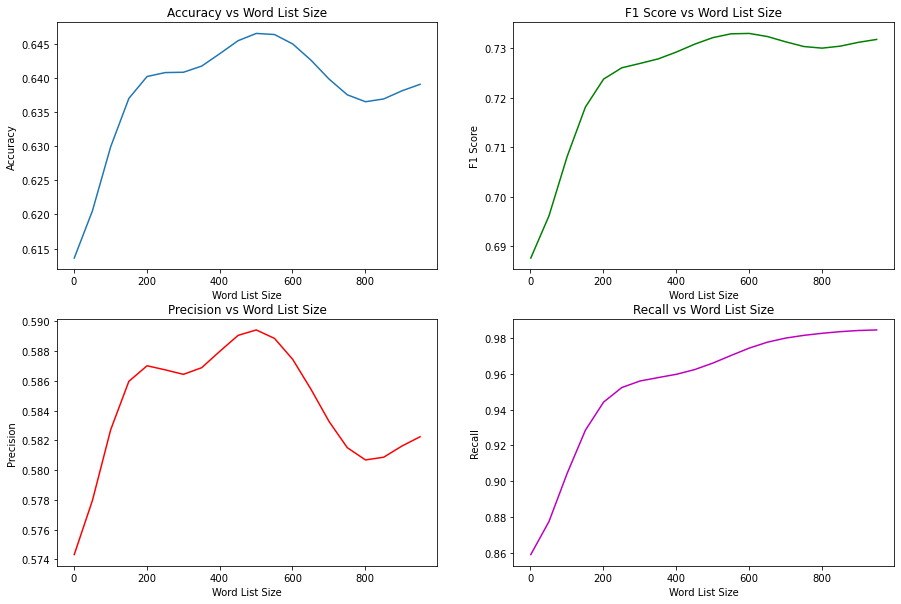

In [25]:
explen = len(experiments)

#get lists of metrics for each instance k and the element 0,5,6,7 of k
accur = [experiments[k][0] for k in range(explen)]
precis =[experiments[k][5] for k in range(explen)]
recall = [experiments[k][6] for k in range(explen)]
f1sc = [experiments[k][7] for k in range(explen)]

from scipy.ndimage.filters import gaussian_filter1d #for nice smooth plots
#smooth all data
acc2 = gaussian_filter1d(accur, sigma=2)
f12 = gaussian_filter1d(f1sc, sigma=2)
prec = gaussian_filter1d(precis, sigma=2)
rec =  gaussian_filter1d(recall, sigma=2)

fig,ax = plt.subplots(figsize=(15, 10))
#accuracy plot
plt.subplot(2,2,1)
plt.title("Accuracy vs Word List Size")
plt.xlabel("Word List Size")
plt.ylabel("Accuracy")
plt.plot(wrd_list_size, acc2)
#f1 score plot
plt.subplot(2,2,2)
plt.title("F1 Score vs Word List Size")
plt.xlabel("Word List Size")
plt.ylabel("F1 Score")
plt.plot(wrd_list_size, f12, 'g')
#precision plot
plt.subplot(2,2,3)
plt.title("Precision vs Word List Size")
plt.xlabel("Word List Size")
plt.ylabel("Precision")
plt.plot(wrd_list_size,prec, 'r')
#recall plot
plt.subplot(2,2,4)
plt.title("Recall vs Word List Size")
plt.xlabel("Word List Size")
plt.ylabel("Recall")
plt.plot(wrd_list_size,rec,'m')


Part a cont:

The obtained results were a little different than expected. For all metrics, there is a more or less linear relationship between each metric and the word list size up until n = 200. Beyond this, there is further increase although accuracy and precision, and subsequently the F1 score begin to decrease after n = 500-550. One reason for this is that we may find many cases where the n most common words includes those of frequency 1, as according to Zipf's Law, many words will only actually appear once, if at all. Obviously the larger our wordlist becomes, the higher chance we have of including frequencies of just 1. As there is only 1 example to go off, it would be inaccurate to include that word in a particular list (pos or neg.) We could of course apply a frequency threshold, but then the size of our wordlist would be quite limited, given the training data.

As the F1 score should ideally be maximised, it would be recommended to use a word list in the range of 200-500, although the reduction in precision should be considered. Naturally for this skewed positive dataset, the recall would be expected to increase which implicitly causes a decrease in precision, so it depends whether we are willing to make the trade-off.

Part b:

Naive-Bayes would be the recommended option for sentiment classification. Without considering the classification metrics, Naive-Bayes is much quicker to compute than the word list classifier. Throughout this report, it has been evident that large or more varied datasets would be needed to help train classifiers better, which would be fairly problematic for such an iterative approach like the word list classifier. Additionally the Naive-Bayes classifier deals with new words quite well, by just assuming that it has seen the word before, but assigning the word a very low probability for each class. The Word List classifier does not particularly deal with this case which leads to mostly random predictions. Given many words are likely to be unseen in test sets, Naive-Bayes is the more obvious choice.

In [37]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437

import io
from nbformat import current

#filepath="/content/drive/My Drive/NLE Notebooks/assessment/assignment1.ipynb"
filepath="NLassignment2021.ipynb"
question_count=437

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 1833
